In [149]:
#Intro to Deep Learning Bone Fracture X Ray Classification Final Project
##Introduction
###The goal of this project is to classify x ray images as containing a fracture or not. Imaging, such as x rays, are an important part of medicine. They help to identify any abnormalities and help healthcare workers make diagnoses. One good example is being able to analyze any type of bone and identify if there are any fractures present in the x ray images.
###For this particular project, CNN was used to create a model. It classifies the images as 'fractured' or 'not fractured' based on the traiing and learning that it does to analyze images and determine if there is a fracture present in the image. CNNs are especially useful when analyzing and classifying images due to their ability to automatically extract features and utilize spatial structure without compromising accuracy or efficiency.
###The dataset contains both fractured and non-fractured X-ray images from a variety of anatomical body regions, such as lower limbs, upper limbs, hips, knees, etc. It is categorized into train, test, and validation folders. Each of these three folders have both fractured and non-fractured x ray images. There are a total of 10,580 x ray images in the dataset. The training data has 9246 x ray images. There are 828 x ray images in the validation dataset. The test data has 506 x ray images. 
###kaggle link to dataset: https://www.kaggle.com/datasets/bmadushanirodrigo/fracture-multi-region-x-ray-data/data
###GitHub repository link: https://github.com/claire01234/Intro-to-Deep-Learning-Final-Project.git

In [150]:
import matplotlib.pyplot as plt
import glob
import os
import collections
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tqdm import tqdm
from keras.models import Sequential
from pathlib import Path
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
from collections import Counter
from keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [151]:
train_dir = '/Users/ponyp/kaggle/input/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/train/'
test_dir = '/Users/ponyp/kaggle/input/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/test/'
val_dir = '/Users/ponyp/kaggle/input/Bone_Fracture_Binary_Classification/Bone_Fracture_Binary_Classification/val/'

In [152]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                              image_size=(180, 180),
                                                              batch_size=32)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                              image_size=(180, 180),
                                                              batch_size=32)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(val_dir,
                                                              image_size=(180, 180),
                                                              batch_size=32)

Found 9246 files belonging to 2 classes.
Found 506 files belonging to 2 classes.
Found 829 files belonging to 2 classes.


In [153]:
class_names = train_ds.class_names

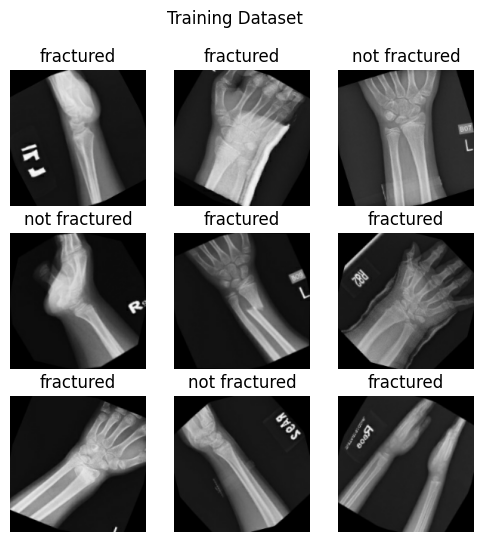

In [154]:
def show_images(dataset, title):
    plt.figure(figsize=(6, 6))
    for images, labels in dataset.take(1):
        for i in range(9):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype('uint8'))
            plt.title(class_names[labels[i]])
            plt.axis('off')
    plt.suptitle(title)
    plt.show()
show_images(train_ds, 'Training Dataset')

In [155]:
def count_classes(dataset, class_name):
    dataset_path = Path(dataset)
    return len(list(dataset_path.glob(f"{class_name}/*")))
def create_class_counts_df(dataset, class_names):
    counts = {'class': [], 'count': []}
    for class_name in class_names:
        counts['class'].append(class_name)
        counts['count'].append(count_classes(dataset, class_name))
    return pd.DataFrame(counts)

In [156]:
class_names = ['fractured', 'not fractured']
train_df = create_class_counts_df(train_dir, class_names)
test_df = create_class_counts_df(test_dir, class_names)
val_df = create_class_counts_df(val_dir, class_names)

/var/folders/t3/zrckpwn54d7_nzjj5bgdlcyc0000gp/T/ipykernel_90559/1415019254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='count', data=df, palette=palette)


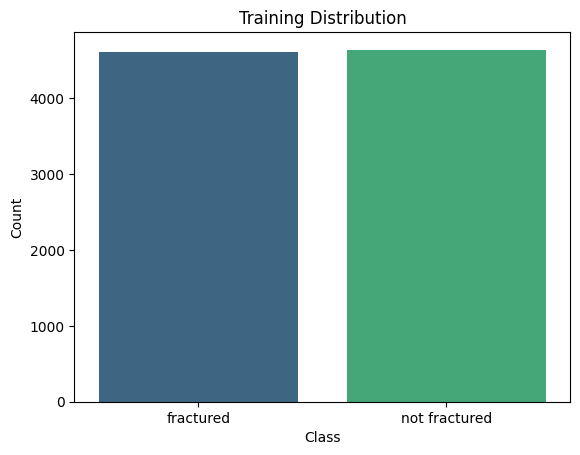

/var/folders/t3/zrckpwn54d7_nzjj5bgdlcyc0000gp/T/ipykernel_90559/1415019254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='count', data=df, palette=palette)


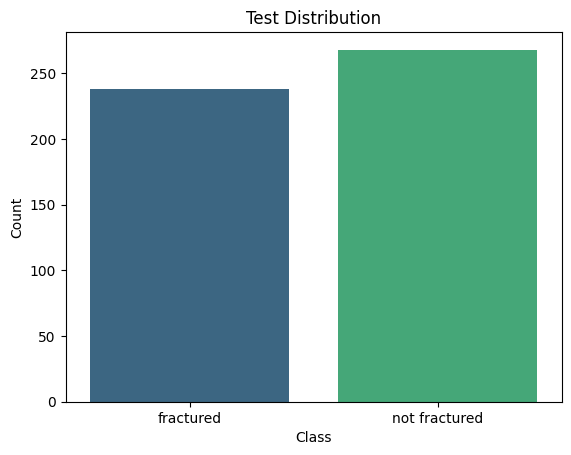

/var/folders/t3/zrckpwn54d7_nzjj5bgdlcyc0000gp/T/ipykernel_90559/1415019254.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='class', y='count', data=df, palette=palette)


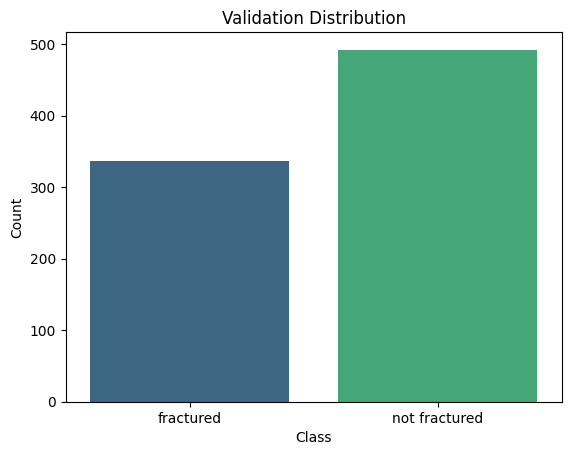

In [179]:
def plot_class_distribution(df, title, palette="viridis"):
    sns.barplot(x='class', y='count', data=df, palette=palette)
    plt.title(title)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.show()
plot_class_distribution(train_df, 'Training Distribution')
plot_class_distribution(test_df, 'Test Distribution')
plot_class_distribution(val_df, 'Validation Distribution')

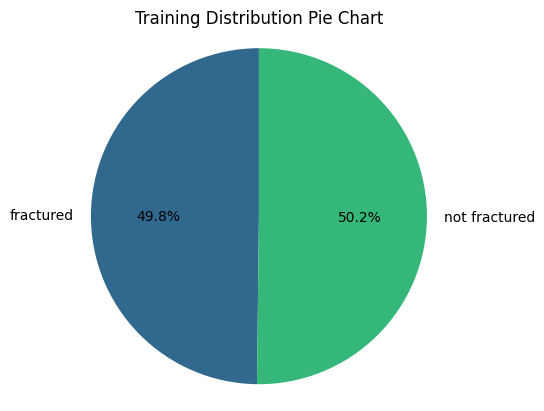

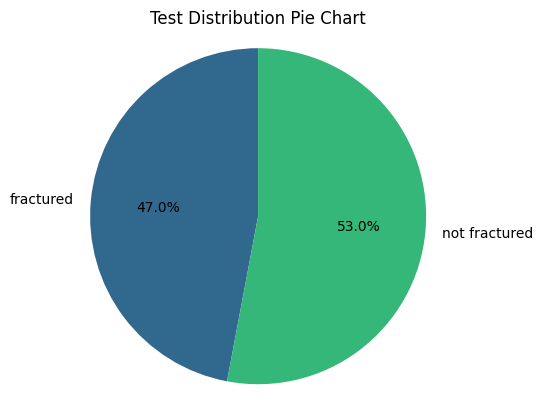

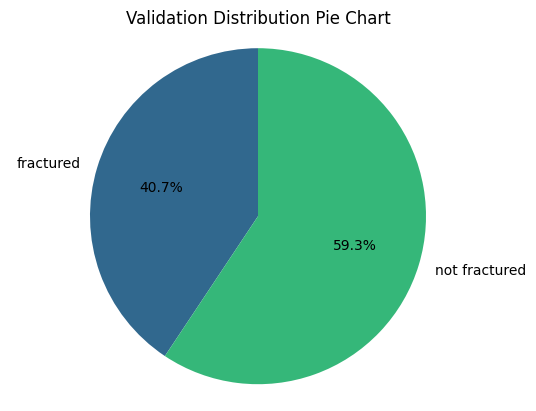

In [158]:
def plot_class_pie_chart(df, title):
    plt.pie(df['count'], labels=df['class'], autopct='%1.1f%%', startangle=90, colors=sns.color_palette('viridis', len(df)))
    plt.title(title)
    plt.axis('equal') 
    plt.show()
plot_class_pie_chart(train_df, 'Training Distribution Pie Chart')
plot_class_pie_chart(test_df, 'Test Distribution Pie Chart')
plot_class_pie_chart(val_df, 'Validation Distribution Pie Chart')

In [159]:
train_datagen = ImageDataGenerator(rescale=1./255,
    rotation_range=5,  
    width_shift_range=0.05,  
    height_shift_range=0.05,
    horizontal_flip=True
)
test_datagen = ImageDataGenerator(rescale=1.0/255)
val_datagen = ImageDataGenerator(rescale=1.0/255)

In [160]:
training_set = train_datagen.flow_from_directory(train_dir,
                                                target_size=(180, 180),
                                                batch_size=32,
                                                class_mode='binary')
test_set = train_datagen.flow_from_directory(test_dir,
                                                target_size=(180, 180),
                                                batch_size=32,
                                                class_mode='binary')
val_set = train_datagen.flow_from_directory(val_dir,
                                                target_size=(180, 180),
                                                batch_size=32,
                                                class_mode='binary')

Found 9246 images belonging to 2 classes.
Found 506 images belonging to 2 classes.
Found 829 images belonging to 2 classes.


In [162]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
model = Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')
])
model.summary()
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history = model.fit(training_set, 
                    validation_data=val_set, 
                    epochs=15, 
                    batch_size=32)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 540,193 (2.06 MB)

 Trainable params: 540,193 (2.06 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step - accuracy: 0.5932 - loss: 0.6630

/Users/ponyp/.pyenv/versions/3.11.13/lib/python3.11/site-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


289/289 ━━━━━━━━━━━━━━━━━━━━ 66s 225ms/step - accuracy: 0.5934 - loss: 0.6628 - val_accuracy: 0.7961 - val_loss: 0.4987
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 71s 246ms/step - accuracy: 0.7904 - loss: 0.4555 - val_accuracy: 0.7780 - val_loss: 0.4945
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 75s 258ms/step - accuracy: 0.8820 - loss: 0.2819 - val_accuracy: 0.8987 - val_loss: 0.3157
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 74s 257ms/step - accuracy: 0.9186 - loss: 0.2087 - val_accuracy: 0.9047 - val_loss: 0.2434
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 77s 266ms/step - accuracy: 0.9421 - loss: 0.1529 - val_accuracy: 0.9216 - val_loss: 0.2259
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 83s 286ms/step - accuracy: 0.9530 - loss: 0.1258 - val_accuracy: 0.9300 - val_loss: 0.2579
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 81s 281ms/step - accuracy: 0.9591 - loss: 0.1108 - val_accuracy: 0.9385 - val_loss: 0.2044
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 81s 279ms/step - accuracy: 0.9761 - loss: 0.0803 - val

In [163]:
test_loss, test_acc = model.evaluate(test_set)
print(f'Test Accuracy: {test_acc:.2f}')
print(f'Test Loss: {test_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 229ms/step - accuracy: 0.9763 - loss: 0.0800
Test Accuracy: 0.97
Test Loss: 0.08


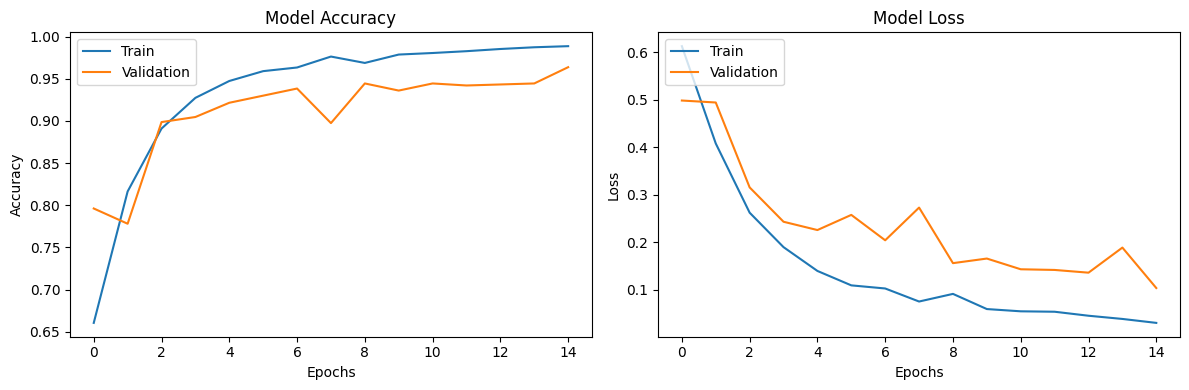

In [169]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Model Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [165]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
model2 = Sequential([
    layers.InputLayer(input_shape=(180, 180, 3)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Conv2D(256, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.5),  
    layers.Dense(1, activation='sigmoid')
])
model2.summary()
model2.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
history_model2 = model2.fit(training_set, 
                    validation_data=val_set, 
                    epochs=15, 
                    batch_size=32)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)              │ (None, 178, 178, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 89, 89, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 89, 89, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 87, 87, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 43, 43, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 41, 41, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 20, 20, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 20, 20, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 18, 18, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 9, 9, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 7, 7, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 3, 3, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 3, 3, 256)      │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │       147,520 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 542,177 (2.07 MB)

 Trainable params: 541,185 (2.06 MB)

 Non-trainable params: 992 (3.88 KB)

Epoch 1/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 114s 391ms/step - accuracy: 0.7449 - loss: 0.5848 - val_accuracy: 0.4451 - val_loss: 1.0045
Epoch 2/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 112s 387ms/step - accuracy: 0.8824 - loss: 0.3018 - val_accuracy: 0.7901 - val_loss: 0.6471
Epoch 3/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 118s 406ms/step - accuracy: 0.9116 - loss: 0.2351 - val_accuracy: 0.8987 - val_loss: 0.2742
Epoch 4/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 111s 385ms/step - accuracy: 0.9333 - loss: 0.1758 - val_accuracy: 0.9168 - val_loss: 0.2190
Epoch 5/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 110s 381ms/step - accuracy: 0.9528 - loss: 0.1279 - val_accuracy: 0.7708 - val_loss: 0.6517
Epoch 6/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 112s 387ms/step - accuracy: 0.9544 - loss: 0.1278 - val_accuracy: 0.9204 - val_loss: 0.1942
Epoch 7/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 100s 346ms/step - accuracy: 0.9721 - loss: 0.0816 - val_accuracy: 0.9373 - val_loss: 0.1616
Epoch 8/15
289/289 ━━━━━━━━━━━━━━━━━━━━ 106s 368ms/step - accuracy: 0.9681 -

In [166]:
test_loss, test_acc = model2.evaluate(test_set)
print(f'Test Accuracy: {test_acc:.2f}')
print(f'Test Loss: {test_loss:.2f}')

16/16 ━━━━━━━━━━━━━━━━━━━━ 4s 228ms/step - accuracy: 0.8815 - loss: 0.4427
Test Accuracy: 0.89
Test Loss: 0.40


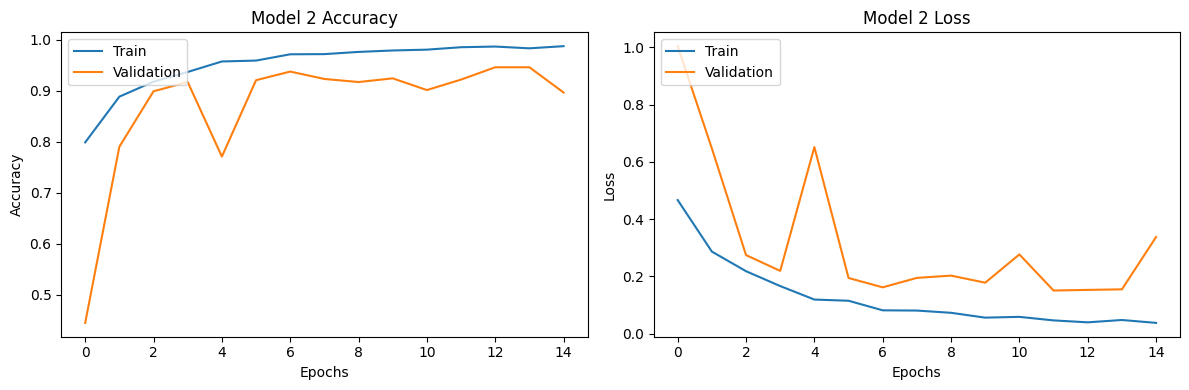

In [170]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title("Model 2 Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplot(1, 2, 2)
plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title("Model 2 Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(['Train', 'Validation'], loc='upper left')
plt.tight_layout()
plt.show()

In [180]:
##Resutls
###For model 1, the best accuracy was 0.9897, the lowest loss value was 0.0316, the best validation accuracy was 0.9638, and the lowest validation loss was 0.1038.
###For model 1, the test accuracy was 0.97 and the test loss was 0.08.
###For the second model, the best accuracy was 0.9886, the lowest loss was 0.0339, the best validation accuracy was 0.9457, and the lowest validation loss was 0.1504.
###In the test data for model 2, the accuracy was 0.89 and loss was 0.4.

In [ ]:
##Discussion/Conclusion
###The first model performed better than the second model because it had a better accuracy and lower loss for all of the datasets (training, validation, and test).
###Changing the hyperparameters or what layers are included can alter the model's performance and accuracy.
###In the future, it could be possible to try other types of models like GAN or RNN to see how they perform and if they can get a better accuracy than CNN models.